# Imports

In [85]:
import pandas as pd
import numpy as np
import time
import json
from pathlib import Path
import tifffile as tif
import networkx as nx
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import write_dot, graphviz_layout

# Function definitions

In [53]:
def group_level_from_root(g,root,max_level):
    """ get descendants from a graph g, a root value, and a max_level
    makes a list of the descendants of root, and for each of those descendents, gets
    any further descendents up until max_level is reached. e.g. if max_level is 3,
    root is 1, root's children and grandchildren would all be included in desc"""
    desc = list(nx.descendants(g,root))
    level=1
    for child in desc:
        if str(child) in g and len(nx.descendants(g,str(child))) > 0 and level < max_level:
            for grandchild in list(nx.descendants(g,str(child))):
                if str(grandchild) in g:
                    desc.append(str(grandchild))
            level+=1
    return desc

In [54]:
def find_roots(g):
    """ in a given digraph, find the root value(s)"""
    root=[]
    for gg in g:
        if gg != 'root':
            if len(sg.in_edges(int(gg))) < 1:
                root.append(gg)
    return root

In [55]:
def get_desc_from_vals(g,vals):
    """ takes a digraph g and a list of values, and then finds all descendants of those values
    next it finds all descendants and descendants' descendants"""
    for val in vals:
        desc = list(nx.descendants(g,val))
        for dec in desc:
            if dec in g and dec != val:
                vals.append(dec)
            if str(dec) in g and dec != val:
                vals.append(str(dec))
    return vals

# User inputs

In [7]:
df = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels_updated/PRA_labels_with-graph-order_children_parents.csv')
df.head(2)

,id,name,parent_id
0,0,NaN,root
1,35,brainstem,449


In [56]:
df['region_name']=df['name']

In [61]:
df.drop(columns=['name'])

,id,parent_id,region_name
0,0,root,NaN
1,35,449,brainstem
2,36,449,cerebellum
3,37,449,cerebrum
4,243,450,corpus_collosum
...,...,...,...
612,475,607,accumbens_nucleus
613,476,607,olfactory_tubercle
614,477,607,striatum_fundus
615,132,74,cuneate_fascicle


In [64]:
g = nx.DiGraph()

for index, row in df.iterrows():
    g.add_node(row.id,region_id=row.id,region_name=row.region_name,cell_count=np.random.randint(10))
    g.add_edge(row.parent_id,row.id)


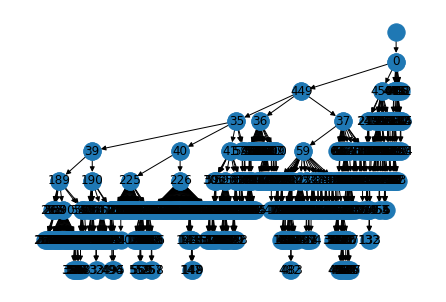

In [65]:
labels = nx.get_node_attributes(g, 'region_id')
pos =graphviz_layout(g, prog='dot')
nx.draw(g, pos, with_labels=True,labels=labels, arrows=True)

Text(0.5, 1.0, 'all nodes and edges')

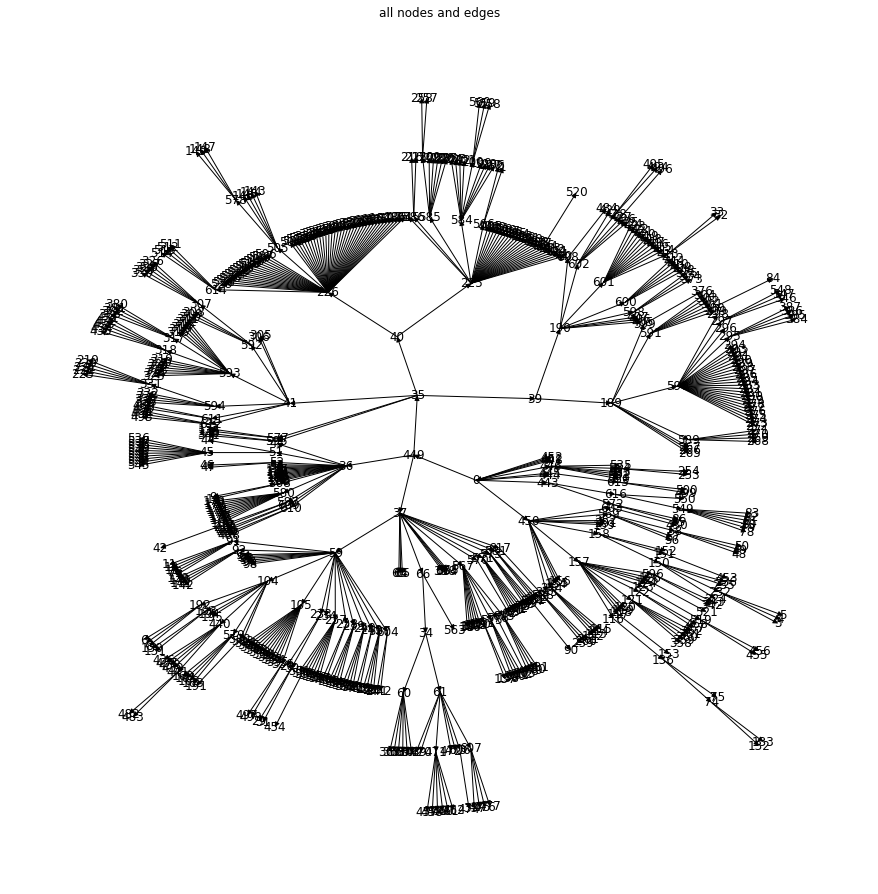

In [66]:
plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(g,'region_id')
pos = graphviz_layout(g, prog="twopi", args="")
nx.draw(g, pos, labels=labels,arrows=True,node_size=0)
plt.title('all nodes and edges')

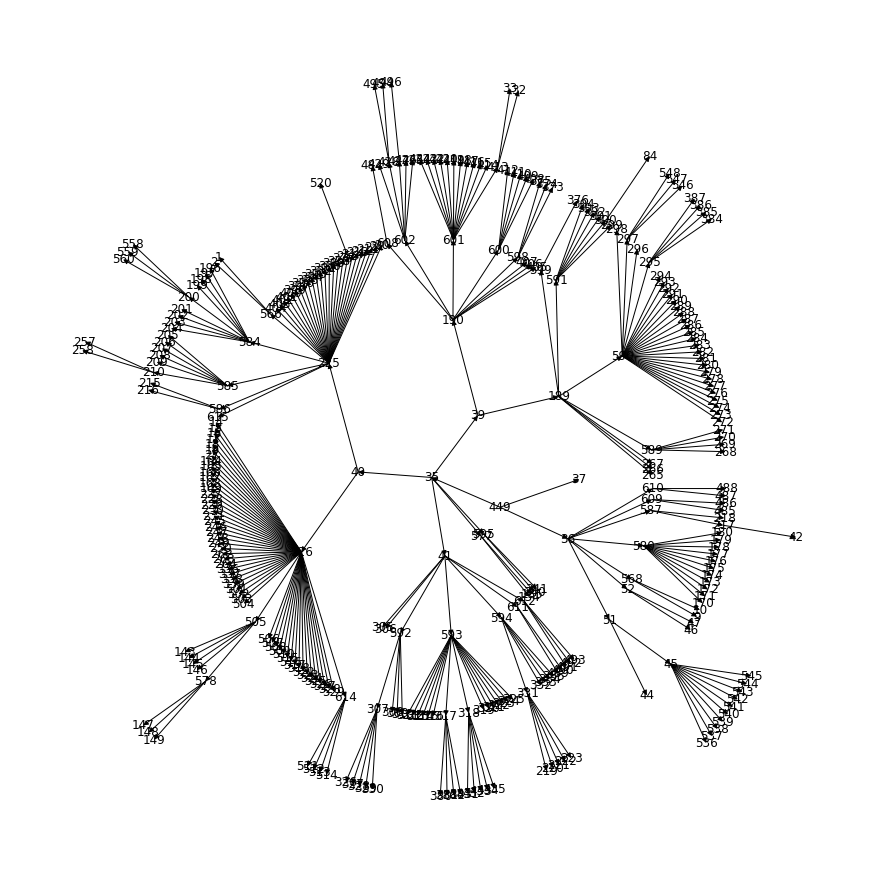

In [67]:
num = 449
sg=g.copy()
vals = get_desc_from_vals(sg,group_level_from_root(sg,str(num),3))

badvals = []
vallist=[]
for val in vals:
    vallist.append(str(val))

for node in list(sg.nodes()):
    if str(node) not in vallist and str(node) != str(num):
        badvals.append(node)

sg.remove_nodes_from(badvals)

plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(sg,'region_id')
pos = graphviz_layout(sg, prog="twopi", args="")
nx.draw(sg, pos, labels=labels, arrows=True,node_size=0)


In [17]:
nx.write_gexf(sg,'/Users/emilydennis/Desktop/lightsheet/pra_ingexf_subg.gexf')

In [68]:
list_of_nodes = list(sg.nodes(data=True))

[(35, {'region_id': 35, 'region_name': 'brainstem', 'cell_count': 5}),
 ('449', {}),
 (36, {'region_id': 36, 'region_name': 'cerebellum', 'cell_count': 4}),
 (37, {'region_id': 37, 'region_name': 'cerebrum', 'cell_count': 0}),
 (449,
  {'region_id': 449,
   'region_name': 'basic_cell_groups_and_regions',
   'cell_count': 9}),
 (39, {'region_id': 39, 'region_name': 'hindbrain', 'cell_count': 5}),
 ('35', {}),
 (40, {'region_id': 40, 'region_name': 'interbrain', 'cell_count': 7}),
 (41, {'region_id': 41, 'region_name': 'midbrain', 'cell_count': 3}),
 (577,
  {'region_id': 577, 'region_name': 'dorsal_column_nuclei', 'cell_count': 0}),
 (595,
  {'region_id': 595,
   'region_name': 'nucleus_of_the_lateral_lemniscus',
   'cell_count': 2}),
 ('36', {}),
 (51, {'region_id': 51, 'region_name': 'cerebellar_cortex', 'cell_count': 4}),
 (52, {'region_id': 52, 'region_name': 'cerebellar_nuclei', 'cell_count': 8}),
 (568, {'region_id': 568, 'region_name': 'ansiform_lobule', 'cell_count': 2}),
 (580,

# notes from conversations with Nick on 2021_05_13

| id | region | cell_counts |
| :-:| :-:    |  :--:       |
| 3  | hippo. | 3 | 
| 4  | CA1    | 10| 
| 5  | basal ganglia | 5|

- hippo 3
  - CA1 10
- basal ganglia 5

subset tree by level
- hippo 13
- bg 5

| id | region | cell_counts | level1 | level2 | level3 | 
| :-:| :-:    |  :--:       | :---: | | :----: | | :-----: |
| 3  | hippo. | 13 |  0 | 
| 5  | basal ganglia | 5|  |
|0   | root | 0 | 123091 | 200 | 100 | ..

In [70]:
# level - id - region - cell_counts - children_included
# 1 - 0 - root - 123091 
# 2 - 0 - root - 200 
# 2 - 3 - hippocampus - 13

# cell counts example

In [74]:
cells = np.load('/Users/emilydennis/Desktop/posttransformed_zyx_voxels.npy')
np.shape(cells)

(686858, 3)

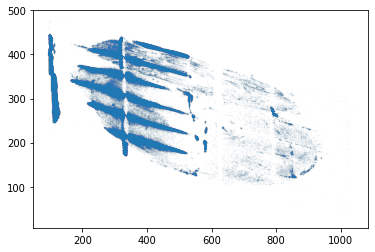

In [81]:
plt.scatter(cells[:,0],cells[:,1],s=.1,alpha=0.05)

In [125]:
sigma_ann_eroded = tif.imread('/Users/emilydennis/Desktop/lightsheet/images/SIGMA_ann_in_mPRA_90um_edge_90um_vent_erosion.tif')
sigma_labs = pd.read_csv('/Users/emilydennis/Desktop/lightsheet/labels_updated/sigma_withPRA.csv')

In [123]:
sigma_labs = sigma_labs.drop(columns=['Unnamed: 0'])

In [124]:
sigma_labs

,atlas,ID,label,pra_id,name,common_name,parent_id,graph_order,children,has_children,parent_ids
0,Tohoku,11,Agranular Dysgranular Insular Cortex,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
1,Tohoku,12,Agranular Dysgranular Insular Cortex,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
2,Tohoku,21,Agranular Insular Cortex,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
3,Tohoku,22,Agranular Insular Cortex,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
4,Tohoku,31,Amygdalohyppocampic Area,109,amygdalohyppocampic_area,amygdalohippocampal_cortex,567,3,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...
229,Waxholm,1152,Ventral Hippocampal Commissure,163,ventral_hippocampal_commissure,hippocampal_commissure,579,5,[],0,0
230,Waxholm,1161,Periventricular Grey,211,periventricular_grey,periventricular_region,225,4,[],0,0
231,Waxholm,1162,Periventricular Grey,211,periventricular_grey,periventricular_region,225,4,[],0,0
232,SIGMA,1171,Ventricular System,446,ventricular_system,ventricular_systems,0,1,[],0,0


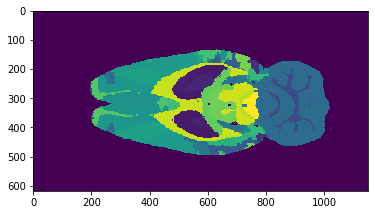

In [126]:
plt.imshow(sigma_ann_eroded[:,:,100])

In [133]:
# TODO turn below into a fx in a script

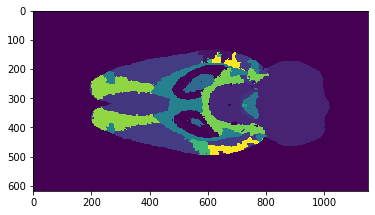

In [129]:
for sigma_id in sigma_labs.ID:
    sigma_ann_eroded[sigma_ann_eroded==sigma_id]=sigma_labs[sigma_labs.ID==sigma_id].pra_id
plt.imshow(sigma_ann_eroded[:,:,100])

In [132]:
tif.imsave('/Users/emilydennis/Desktop/lightsheet/images/sigma_eroded_with_PRAids_in_mPRA.tif',sigma_ann_eroded)

# plot

what now?
I have cell coordinates in x,y,z (or z,y,x?)
I have a 3d volume that has values at those coordinates
and I have a tree that relates different values/ids to a higher structure

I need to either make a 3d matrix and put 1s where the cells are, or get the value for the cells. let's try #1 first

In [198]:
bool_cell_matrix = np.zeros(np.shape(sigma_ann_eroded))

In [335]:
for cell in cells:
    vals = cell.astype(int)
    bool_cell_matrix[vals[2],vals[0],vals[1]]=1

IndexError: index 398 is out of bounds for axis 2 with size 385

In [204]:
cell_PRAid_matrix = bool_cell_matrix*sigma_ann_eroded

In [189]:
sigma_labs.insert(4,'cell_count',0)
sigma_labs

,Unnamed: 0,atlas,ID,label,cell_count,pra_id,name,common_name,parent_id,graph_order,children,has_children,parent_ids
0,0,Tohoku,11,Agranular Dysgranular Insular Cortex,0,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
1,1,Tohoku,12,Agranular Dysgranular Insular Cortex,0,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
2,2,Tohoku,21,Agranular Insular Cortex,0,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
3,3,Tohoku,22,Agranular Insular Cortex,0,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
4,4,Tohoku,31,Amygdalohyppocampic Area,0,109,amygdalohyppocampic_area,amygdalohippocampal_cortex,567,3,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
229,229,Waxholm,1152,Ventral Hippocampal Commissure,0,163,ventral_hippocampal_commissure,hippocampal_commissure,579,5,[],0,0
230,230,Waxholm,1161,Periventricular Grey,0,211,periventricular_grey,periventricular_region,225,4,[],0,0
231,231,Waxholm,1162,Periventricular Grey,0,211,periventricular_grey,periventricular_region,225,4,[],0,0
232,232,SIGMA,1171,Ventricular System,0,446,ventricular_system,ventricular_systems,0,1,[],0,0


In [206]:
sum(cell_PRAid_matrix[cell_PRAid_matrix==28])

30800.0

In [260]:
for index, row in sigma_labs.iterrows():
    #print(row.pra_id)
    sigma_labs.loc[index,'cell_count'] = np.sum(cell_PRAid_matrix[cell_PRAid_matrix==row.pra_id])
    
    

In [258]:
sigma_labs.loc[100,'cell_count'] = np.sum(cell_PRAid_matrix[cell_PRAid_matrix==463])

In [264]:
sigma_labs=sigma_labs.drop(columns=['Unnamed: 0'])

In [265]:
sigma_labs

,atlas,ID,label,cell_count,pra_id,name,common_name,parent_id,graph_order,children,has_children,parent_ids
0,Tohoku,11,Agranular Dysgranular Insular Cortex,0.0,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
1,Tohoku,12,Agranular Dysgranular Insular Cortex,0.0,150,agranular_dysgranular_insular_cortex,insular_cortex,158,3,"[224, 232, 235, 236, 3, 4, 5]",1,0
2,Tohoku,21,Agranular Insular Cortex,10672.0,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
3,Tohoku,22,Agranular Insular Cortex,10672.0,232,agranular_insular_cortex,agranular_insular_cortex,150,4,"[3, 4, 5]",1,0
4,Tohoku,31,Amygdalohyppocampic Area,0.0,109,amygdalohyppocampic_area,amygdalohippocampal_cortex,567,3,[],0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
229,Waxholm,1152,Ventral Hippocampal Commissure,0.0,163,ventral_hippocampal_commissure,hippocampal_commissure,579,5,[],0,0
230,Waxholm,1161,Periventricular Grey,0.0,211,periventricular_grey,periventricular_region,225,4,[],0,0
231,Waxholm,1162,Periventricular Grey,0.0,211,periventricular_grey,periventricular_region,225,4,[],0,0
232,SIGMA,1171,Ventricular System,0.0,446,ventricular_system,ventricular_systems,0,1,[],0,0


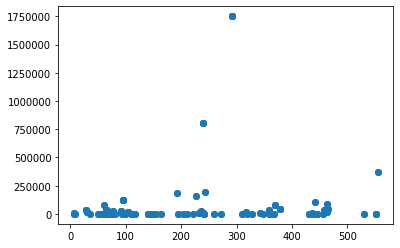

In [267]:
plt.scatter(sigma_labs.pra_id,sigma_labs.cell_count)

# now to make a fresh dataframe using level info

In [269]:
# to do this I need to move UP the tree, 
# not just cull parts of the tree.

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


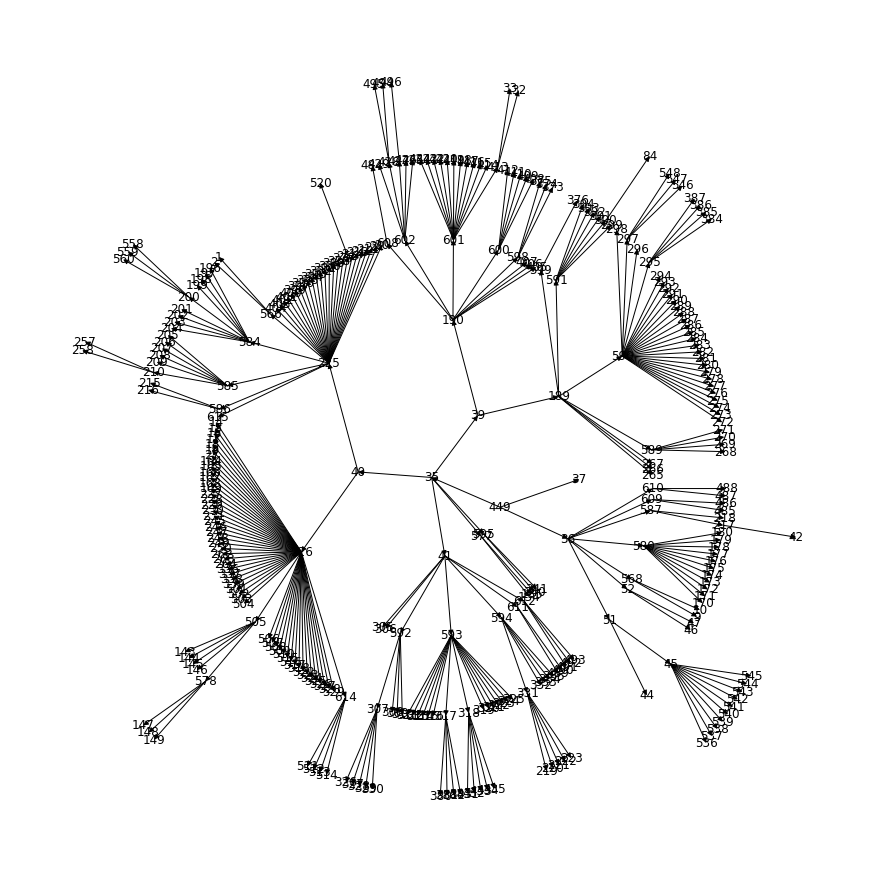

In [270]:
plt.figure(figsize=(12, 12))
labels=nx.get_node_attributes(sg,'region_id')
pos = graphviz_layout(sg, prog="twopi", args="")
nx.draw(sg, pos, labels=labels, arrows=True,node_size=0)

In [271]:
# remade previous subsetted graph above
# now I want to include the outermost layers in the innermost layers 

In [275]:
y = [x for x in sg.nodes() if sg.out_degree(x)==0]

#[x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1]
#(x for x in G.nodes() if G.out_degree(x)==0 and G.in_degree(x)==1)


In [289]:
terminal_nodes = [x for x in sg.nodes() if sg.out_degree(x)==0]

[35,
 36,
 37,
 449,
 39,
 40,
 41,
 577,
 595,
 51,
 52,
 568,
 580,
 587,
 609,
 610,
 '37',
 189,
 190,
 225,
 226,
 305,
 306,
 592,
 593,
 594,
 611,
 612,
 134,
 135,
 340,
 341,
 44,
 45,
 46,
 47,
 9,
 10,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 217,
 218,
 485,
 486,
 487,
 488,
 265,
 266,
 267,
 589,
 590,
 591,
 599,
 405,
 406,
 407,
 598,
 600,
 601,
 602,
 608,
 20,
 21,
 22,
 211,
 212,
 213,
 214,
 256,
 377,
 388,
 389,
 390,
 391,
 392,
 393,
 394,
 395,
 396,
 397,
 399,
 400,
 401,
 402,
 403,
 404,
 566,
 584,
 585,
 586,
 615,
 14,
 15,
 16,
 17,
 18,
 19,
 27,
 164,
 165,
 166,
 167,
 168,
 169,
 227,
 228,
 229,
 230,
 231,
 245,
 246,
 247,
 248,
 249,
 250,
 262,
 263,
 264,
 336,
 337,
 338,
 339,
 501,
 502,
 503,
 504,
 505,
 506,
 507,
 508,
 509,
 510,
 515,
 516,
 517,
 518,
 522,
 523,
 524,
 525,
 526,
 527,
 528,
 529,
 614,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 314,
 315,
 316,
 317,
 318,
 319,
 320,
 321,
 322,
 323

In [321]:
sg.nodes()

NodeView((35, '449', 36, 37, 449, 39, '35', 40, 41, 577, 595, '36', 51, 52, 568, 580, 587, 609, 610, '37', 189, '39', 190, 225, '40', 226, 305, '41', 306, 592, 593, 594, 611, 612, 134, '577', 135, 340, '595', 341, 44, '51', 45, 46, '52', 47, 9, '568', 10, 170, '580', 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 217, '587', 218, 485, '609', 486, 487, '610', 488, 265, '189', 266, 267, 589, 590, 591, 599, 405, '190', 406, 407, 598, 600, 601, 602, 608, 20, '225', 21, 22, 211, 212, 213, 214, 256, 377, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 399, 400, 401, 402, 403, 404, 566, 584, 585, 586, 615, 14, '226', 15, 16, 17, 18, 19, 27, 164, 165, 166, 167, 168, 169, 227, 228, 229, 230, 231, 245, 246, 247, 248, 249, 250, 262, 263, 264, 336, 337, 338, 339, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 515, 516, 517, 518, 522, 523, 524, 525, 526, 527, 528, 529, 614, 307, '592', 308, 309, 310, 311, '593', 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 331, '594

In [310]:
?nx.shortest_path_length